# Modeling task specific biases in task-switching experiments using asymmetrical dynamical systems

## By Marcel Schindler, Max Wassermann, Sigur Stück, Till Becker & Tjark Darius

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


## Define functions used in model
### Thanks to the teaching assistants for supplying many of these in problemset 4

In [1]:
# load neccessary libraries
import numpy as np # for math stuff
import pandas as pd # for data stuff
from matplotlib import pyplot as plt # for plotting stuff
from scipy.integrate import solve_ivp # used in model to calculate activations
from scipy.optimize import fsolve # used in model to calculate activations
from scipy.special import kl_div # used to determine fit of model and data

In [2]:
def S(g, net):
		"""Logistic saturation function, with slope modulated by a gain parameter

		Inputs
		--------
		g: positive scalar neuronal gain
		y: net input to the neural processing unit

    Output
		-------
    sigmoid activation
		"""

		return 1/(1 + np.exp(-g*net))


def sim_trajectories(t, x, g, I1, I2, sigma, w_1_2=1, w_2_1=1, w_1_1=2, w_2_2=2):
		""" Dynamical model

    Inputs
		------
		t: scalar time (you can ignore this variable)
		x: array [x1,x2] of activities of the neural units corresponding to tasks 1,2
		g: gain
		I1: input to x_1 (cue for task 1)
		I2: input to x_2 (cue for task 2)
		sigma: standard deviation of Gaussian noise added to the net input
    w_{12}, w{21} = 1 : inhibitory weights
    w_{11}, w{22} = 2 : excitory weights


		Output
		-------
		dx1/dt(t,x)
		dx2/dt(t,x)

		"""
		# inhibitory weights
		w1_2 = w_1_2
		w2_1 = w_2_1

		# excitory weights
		w1_1 = w_1_1
		w2_2 = w_2_2

		# initial conditions
		x1 = x[0]
		x2 = x[1]

    # calculate activation trajectory
		dx1_dt =  -x1 + S(g, (w1_1*x1 - w1_2*x2 + I1 + sigma * np.random.normal()))
		dx2_dt =  -x2 + S(g, (w2_2*x2 - w2_1*x1 + I2 + sigma * np.random.normal()))

		return np.array([dx1_dt, dx2_dt])


def get_activations(T, g, I1, I2, sigma, x1_0, x2_0, w_1_2=1, w_2_1=1, w_1_1=2, w_2_2=1, ax=None):
    """ calculate activations of dynamical system at point T

    Inputs
    ------
    T: time to calculate activation for (0 to T)
    g: gain
    I1: input to x_1 (cue for task 1)
    I2: input to x_2 (cue for task 2)
    sigma: standard deviation of Gaussian noise added to the net input
    x1_0, x2_0: initial conditions (activities of the neural units corresponding to tasks 1,2)


    Output
    -------
    dx1/dt(t,x)
    dx2/dt(t,x)

    """
    # Initial condition (x1(0), x2(0))
    x_0 = np.array([x1_0, x2_0])

    # Integrate differential equation
    x_out = solve_ivp(sim_trajectories,
                      np.array([0,T]),
                      x_0,                # initial condition
                      dense_output=True,  # dense_output = True allows us to compute x at any time points on the interval T
                      args = [g, I1, I2, sigma, w_1_2, w_2_1, w_1_1, w_2_2]) # pass additional arguments to the simulation functon

    # First, extract values of the simulation at the desired time grid:
    ts = np.linspace(0,T,100)         # list of 100 evenly spaced points in the time interval we are considering
    xt = x_out.sol(ts)                # solution of the integral at the specified time points
    x1 = xt[0,:]                      # the values of x1(t) are in the first column of the matrix xt
    x2 = xt[1,:]                      # the values of x2(t) are in the second column of the matrix xt

    return x1[-1], x2[-1]



def run_ddm(drift_rate = 1, threshold = 1, starting_point = 0.5, noise_std = 1, non_decision_time = 0, dt = 0.01, max_time = 200):
		"""
		Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Inputs
		------
		drift_rate: rate of evidence accumulation
		threshold: evidence needed to reach a decision
		starting_point: initial condition of the evidence
		noise_std: standard deviation of the noise term
		non_decision_time: time not included in the evidence accumulation process
		dt: time increment
		max_time: maximum simulation time


		Output
		-------
		decision_time: the time taken to reach a decision
		evidence_over_time: the evidence accumulated over time
		decision: 1 if the decision boundary reached is the upper threshold, -1 if lower

    """
		# Initialize evidence accumulation process
		time = non_decision_time
		evidence = starting_point
		evidence_over_time = [evidence]
		lower_bound = 0
		quarter = (max_time / 4)
		steps = (threshold / 2) / (quarter / dt)

		# Run the simulation until a decision boundary is reached or max time is exceeded
		while time < max_time:
				# Increment the evidence by the drift and some noise
				evidence += drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal()
				evidence_over_time.append(evidence)
				time += dt  # Increment the time
				if time > max_time - quarter:
					threshold -= steps
					lower_bound += steps

				# Check if the evidence has reached either threshold
				if evidence >= threshold:
						return time, evidence_over_time, 1  # Decision made for the upper threshold
				elif evidence <= lower_bound:
						return time, evidence_over_time, -1  # Decision made for the lower threshold

		# If no decision has been made by max_time, return the current state
		return time, evidence_over_time, np.random.choice([-1,1])



def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):
		""" plots the distribution of reaction times splitted into correct decisions and errors

		Inputs
		------
		rt_upper_simulated, rt_lower_simulated: the data simulated by the model
		rt_upper_empirical = None, rt_lower_empirical = None: the empirical data, created by humans
		y_max = 0.5: the limit on the y axis

		Outputs
		-------
		returns nothing, simply creates plots of distribution of reaction times
		"""
		# Calculate the weights for each group to normalize the histograms
		weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
		weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

		if rt_upper_empirical is not None and rt_lower_empirical is not None:
			weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
			weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

		# set up figure
		fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

		# Plot the histograms for upper threshold
		axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
		if rt_upper_empirical is not None:
			axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
		axs[0].set_xlabel('Reaction Time (seconds)')
		axs[0].set_ylabel('Normalized Frequency')
		axs[0].legend()
		axs[1].set_ylim([0, y_max])
		axs[0].set_title('Correct')

		# Plot the histograms for lower threshold
		axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
		if rt_upper_empirical is not None:
			axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
		axs[1].set_xlabel('Reaction Time (seconds)')
		axs[1].set_ylabel('Normalized Frequency')
		axs[1].legend()
		axs[0].set_ylim([0, y_max])
		axs[1].set_title('Errors')

		# Adjust layout
		plt.tight_layout()

		# Display the figure
		plt.show()

All of these functions were supplied by the teaching assistant and adjusted to fit our purposes. <br>
Thus, sim_trajectories() also takes excitory weights as an input and get_activations was modified to not plot the trajectories over time, but to return them.

In [3]:
def calculate_drift(act_1, act_2, S_1, S_2, w_a):
  """ calculate the drift rate

  Inputs
  -------
  act_1, act_2: the net activations of node 1 and node 2 of the dynamical system
  S_1, S_2: Values encoding the Stimulus Dimensions; S_1 for movement & S_2 for orientation
  w_a: a weight to regulate the 'automatic response', when the stimulus (S_1 & S_2) is congruent

  Output
  -------
  drift rate

  """
  return w_a * (S_1 + S_2) + act_1 * S_1 + act_2 * S_2

def get_S_and_I(dataframe, S_1=0.1, S_2=0.1, I_1=1, I_2=1):
  """ retrieve the parameters S and I determined by each trial

  Inputs
  -------
  dataframe: a dataframe containing the empirical data
  S_1, S_2: the values with which the stimulus dimensions should be encoded (sign is determined by direction)
  I_1, I_2: the values which cue the task, I_1 for movement and I_2 for orientation; 0 for when the other task is being done

  Outputs
  -------
	a list of length len(df) for each parameter, thus 4 lists in total, containing the values based on the trials
  all_S_1, all_S_2, all_I_1, all_I_2

  """
  # taken from experiment
  # 0 is right
  # 180 left

  # we set S_1 to be responsible for movement
  # and S_2 for orientation

  # and positive for left
  # and negative for right

  # calculate S
  all_S_1 = np.array(dataframe["coherent_movement_direction"].to_list())
  all_S_2 = np.array(dataframe["coherent_orientation"].to_list())

  all_S_1 = np.where(all_S_1 > 0, S_1, - S_1)
  all_S_2 = np.where(all_S_2 > 0, S_2, - S_2)

  # calculate I
  all_I = np.array(dataframe["task_type"].to_list())

  all_I_1 = np.where(all_I == "mov", I_1, 0)
  all_I_2 = np.where(all_I == "or", I_2, 0)

  return all_S_1, all_S_2, all_I_1, all_I_2


def check_decision(I_1, set_I_1, S_1, S_2, decision, verbose):
		""" checks if the decision by the network was correct or not

		Inputs
		-------
		I_1: the value of I_1 for the trial (dont need I_2 as they are mutually exclusive, meaning when one I is 0 the other is not and vice versa)
		set_I_1: the value we set for I_1 (if I_1 == 0, we still need to now the value of I_1)
		S_1, S_2: the values with which the stimulus dimensions should be encoded (sign is determined by direction)
		decision: decision is either 1 for left and -1 for right
		verbose: boolean, whether to print anything


		Output
		-------
		1 if correct decision, else 0

		"""
		# if I_1 is not 0, then it is a mov task
		# if S_1 is > 0, then the correct answer is left
		if I_1 == set_I_1 and S_1 > 0:
			if decision == -1:
				if verbose : print("incorrect \n")
				return 0
			else:
				if verbose : print("correct \n")
				return 1

		elif I_1 == set_I_1 and S_1 < 0:
			if decision == 1:
				if verbose : print("incorrect \n")
				return 0
			else:
				if verbose : print("correct \n")
				return 1

		elif I_1 != set_I_1 and S_2 > 0:
			if decision == -1:
				if verbose : print("incorrect \n")
				return 0
			else:
				if verbose : print("correct \n")
				return 1

		elif I_1 != set_I_1 and S_2 < 0:
			if decision == 1:
				if verbose : print("incorrect \n")
				return 0
			else:
				if verbose : print("correct \n")
				return 1


def milli_to_sec(row):
		""" converts a dataframe row containing milli seconds to seconds

		Input
		-----
		row: a df row (usally in combination with df.apply)

		Output
		------
		row.rt * 0.001
		"""
		return row.rt * 0.001

Most of these functions are simply for convience and not used in the model, except for calculate_drift(), which is the "connection" between the control and decision module.
The other functions are used to convert the experiment into "machine" form so to say, meaning we convert the trials into values, convert milli seconds to seconds and check if the model made the correct decision, based on the trial data.


In [4]:
def model(T, g, sigma, w_1_2, w_2_1, w_1_1, w_2_2, dataset, I1=1, I2=1, verbose=True, print_hist=False, print_acc_and_score=True, single=False):
    """ the complete model containing both the control and decision modules

    Inputs
    -------
    T: time to return activation from (used in control module)
    g: gain parameter modulating sigmoid saturation function (used in control module)
    sigma: standard deviation for normal gaussian noise (used in control module)
    w_1_2, w_2_1: inhibitory weights (used in control module)
    w_1_1, w_2_2: excitory (recurrent) weights (used in control module)
    dataset: the empirical dataset (dataframe), which gets converted so the model can do the trials too
    I1=1, I2=1: the values which to encode the cue of the task, I1 for movement and I2 for orientation
    verbose=True: boolean, whether to print each trial (rt, decision, etc.)
    print_hist=False: boolean, whether to print the histogram with reaction times after all trials are done
    print_acc_and_score=True: boolean, whether to print the accuracy of the model and the KL divergence if single=False
    single=False: boolean, whether the model should simulate data alone or in comparisson to empirical data (False, if in comparisson)


    Outputs
    -------
    (indirect plots, if desired)
    list of reaction times (& KL divergence if desired)
    """
    # parameters for control
    x1_0 = 0
    x2_0 = 0

    # parameters for decision
    threshold =  0.08
    starting_point = threshold/2
    noise_std = 0.025 #0.15
    non_decision_time = 0.2
    dt = 0.01
    max_time = 1.65


    # parameters between both modules
    w_a = 0.25
    set_S_1 = 0.05
    set_S_2 = 0.05
    set_I_1 = I1
    set_I_2 = I2

    w_1_2 = w_1_2
    w_2_1 = w_2_1

    w_1_1 = w_1_1
    w_2_2 = w_2_2

    # save all activations of experiment to use in control module
    all_activations_1 = [x1_0]
    all_activations_2 = [x2_0]

    # save all reaction times based on decisions
    rt_left = []
    rt_right = []

    # save results for accuracy
    results = []
    all_decisions = []

    # get all S_1 and S_2
    all_S_1, all_S_2, all_I_1, all_I_2 = get_S_and_I(dataset, S_1=set_S_1, S_2=set_S_2, I_1=set_I_1, I_2=set_I_2)

    trial = 1
    # go over experimental data
    for S_1, S_2, I_1, I_2 in zip(all_S_1, all_S_2, all_I_1, all_I_2):


      # first get activations
      act_1, act_2 = get_activations(T, g, I_1, I_2, sigma, all_activations_1[-1], all_activations_2[-1], w_1_2, w_2_1, w_1_1, w_2_2)

      all_activations_1.append(act_1)
      all_activations_2.append(act_2)

      # calculate drift rate
      drift_rate = calculate_drift(all_activations_1[-1], all_activations_2[-1], S_1, S_2, w_a)
      #print(drift_rate)

      # get decision
      decision_time, evidence_over_time, decision = run_ddm(drift_rate, threshold, starting_point, noise_std, non_decision_time, dt, max_time)

      if verbose:
        print("trial : ", trial)
        print("task :", "mov") if I_1 == set_I_1 else print("task :", "or")
        print("decision_time : ", decision_time)
        print("last evidence : ", evidence_over_time[-1])
        if decision != 0:
          print("decision : ", "right") if decision == -1 else print("decision : ", "left")
        else:
          print("no decision made \n")


      if decision != 0:
          pred = check_decision(I_1, set_I_1, S_1, S_2, decision, verbose)
          results.append(pred)

      # taken from problemset
      if pred == 0:
          rt_right.append(decision_time)
      elif pred == 1:
          rt_left.append(decision_time)

      #if trial not in missing:
      all_decisions.append(decision_time)

      trial += 1

    # get empirical values for comparrisson
    filtered_rt_false = dataset[dataset['correct'] == 0]['rt']
    rt_right_empirical = filtered_rt_false.to_numpy()

    filtered_rt_correct = dataset[dataset['correct'] == 1]['rt']
    rt_left_empirical = filtered_rt_correct.to_numpy()

    # plot histogram if desired
    if print_hist:
      if single:
        plot_ddm_histograms(rt_left, rt_right, y_max = 0.25)
      else:
        plot_ddm_histograms(rt_left, rt_right, rt_left_empirical, rt_right_empirical, y_max = 0.25)

    if print_acc_and_score:
      print("model accuracy : ", sum(results)/len(results))

      x = all_decisions
      y = list(filtered_rt_false) + list(filtered_rt_correct)

      score_x = sum(kl_div(x, y, out=None))
      print("model divergence to empirical data (low == good) :", score_x)

      return all_decisions, score_x

    # if single=False, the KL divergence to empirical data will be calculated
    if not single:
      x = all_decisions
      y = list(filtered_rt_false) + list(filtered_rt_correct)
      score_x = sum(kl_div(x, y, out=None))
      return all_decisions, score_x

    return all_decisions


This was the complete model containing many of the defined functions before, making up the dynamical system and the drift diffusion model.
It takes many parameters for providing feedback, which enabled us to finetune the parameters.

In [5]:
# our data is anonymized and uploaded at this repository https://github.com/tjayada/model_task_switching
# in the next few lines we load the data and do a little pre-processing
all_dfs = []
for i in range(5):
  all_dfs.append(pd.read_csv(f"https://raw.githubusercontent.com/tjayada/model_task_switching/main/data/experiment_data_{i+1}.csv"))


df = pd.concat(all_dfs)

df["rt"] = df.apply(milli_to_sec, axis=1)
df = df[df["rt"] > .1] # Remove trials less than 100ms
df = df[df["rt"] < 1.65] # Remove trials greater than 1650ms
dataset = df.copy()

We loaded our data from our repository.

In [6]:
# simulate a single trial using the model with recurrent connection
rt = model(T=0.6, g=3.0, sigma=0.1, w_1_2=1, w_2_1=1, w_1_1=1, w_2_2=0, dataset=dataset.iloc[0:1], verbose=True, print_hist=False, print_acc_and_score=False, single=True)
print(rt)

trial :  1
task : mov
decision_time :  0.8300000000000005
last evidence :  0.08002758176349352
decision :  left
correct 

[0.8300000000000005]


In [7]:
# simulate a single trial using the model with no recurrent connection
rt = model(T=0.6, g=3.0, sigma=0.1, w_1_2=2, w_2_1=3, w_1_1=0, w_2_2=0, dataset=dataset.iloc[0:1], verbose=True, print_hist=False, print_acc_and_score=False, single=True)
print(rt)

trial :  1
task : mov
decision_time :  1.350000000000001
last evidence :  0.07022759782399056
decision :  left
correct 

[1.350000000000001]


All we did here was to simulate a single trial with each model. We set verbose=True, so we get more information, than simply the reaction time. Here we can see, that we did the first trial of the experiment, that the task was to determine the movement of the triangles, that the decision time was 0.7 for the recurrent and 1.1 seconds for the non recurrent model.
We also see the last evidence, meaning the value which crossed the treshold, which decision this led to and whether this was the correct decision for this trial.

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


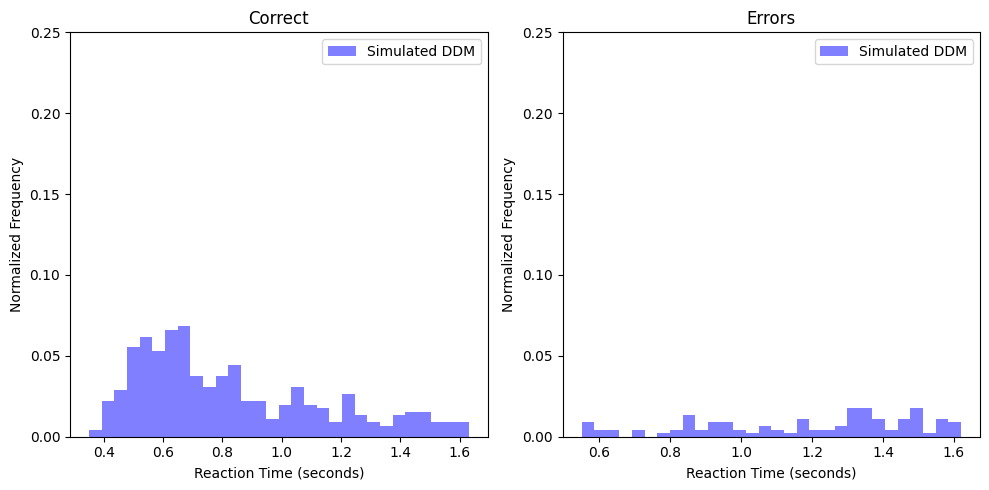

In [8]:
# simulate the whole experiment using the model with recurrent connection
rt = model(T=0.6, g=5.0, sigma=0.1, w_1_2=1, w_2_1=1, w_1_1=1, w_2_2=0, dataset=dataset, verbose=False, print_hist=True, print_acc_and_score=False, single=True)

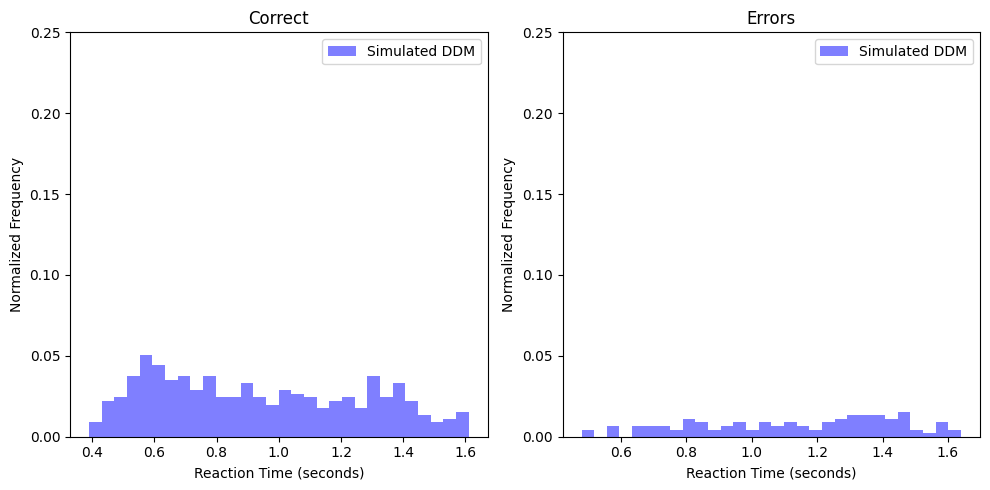

In [9]:
# simulate the whole experiment using the model with no recurrent connection
rt = model(T=0.6, g=5.0, sigma=0.1, w_1_2=2, w_2_1=3, w_1_1=0, w_2_2=0, dataset=dataset, verbose=False, print_hist=True, print_acc_and_score=False, single=True)

We simply called our models to simulate the whole experiment.
We set T=0.6, g=5, sigma=0.1 and the weights depending on whether we want a recurrent model or not.


## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [10]:
# search g from 0 to 10
all_gs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
def MSE(arr_1, arr_2):
  """ calculate the mean squared error

  Inputs
  -------
  arr_1 : the first list of values
  arr_2 : the second list of values

  Output
  -------
  the mean squared difference of both lists
  """
  score = 0
  for v_1, v_2 in zip(arr_1, arr_2):
    score += (v_1 - v_2)**2

  return score/len(arr_1)

In [12]:
def MAE(arr_1, arr_2):
  """ calculate the mean absolute error

  Inputs
  -------
  arr_1 : the first list of values
  arr_2 : the second list of values

  Output
  -------
  the mean absolute difference of both lists
  """
  score = 0
  for v_1, v_2 in zip(arr_1, arr_2):
    score += abs(v_1 - v_2)

  return score/len(arr_1)

The functions above are only used for our knowledge and are calculated for the plot titles of the gain recovery.

In [13]:
def recover_param_g(human_dataset, data, possible_gs, w_1_2=1, w_2_1=1, w_1_1=1, w_2_2=1):
  """ recovers the gain paramter through grid search and KL divergence

  Inputs
  ------
  human_dataset: the empirical dataset, which the model uses to do the same experiment to simulate data
  data: the data simulated by a model, which we try to recover the gain parameter from
  possible_gs: the list of gains, we are iterating over (grid searching)
  w_1_2=1, w_2_1=1: the inhibitory weights the model should use
  w_1_1=1, w_2_2=1: the excitory (recurrent) weights the model should use

  Output
  ------
  the best fitting gain for the simulated data provided
  """
  T = 0.6        # Length of time for the control module
  sigma = 0.1   # noise

  best_g = None
  best_score = 1000000

  for g in possible_gs:
    # simulate data
    model_1 = model(T, g, sigma, w_1_2=w_1_2, w_2_1=w_2_1, w_1_1=w_1_1, w_2_2=w_2_2, dataset=human_dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)
    # determine fit based on KL divergence
    score_x = sum(kl_div(model_1, data, out=None))

    if score_x < best_score:
      best_score = score_x
      best_g = g

  return best_g

This function essentially is iterating over a range of gains, trying to determine the gain the model that simulated the provided data may used.

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [14]:
# range of gains to try
all_gs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fitted_gs_recc = []
tries = 10

# iterate over list of gains trying to find best fit
for g in all_gs:
  # inhibitory
  w_1_2=1
  w_2_1=1
  # excitory
  w_1_1=1
  w_2_2=0.0

  temp = []
  # do multiple times for more solid estimate
  for i in range(tries):
    # simulate data based on parameters above
    created_data = model(0.6, g, 0.1, w_1_2=w_1_2, w_2_1=w_2_1, w_1_1=w_1_1, w_2_2=w_2_2, dataset=dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)
    # use recover function to determine the g, the model above used
    temp.append(recover_param_g(dataset, created_data, all_gs, w_1_2=w_1_2, w_2_1=w_2_1, w_1_1=w_1_1, w_2_2=w_2_2))
  # use average for more solid estimate of recoverbility
  fitted_gs_recc.append(sum(temp) / tries)


Now we just used the recover_param_g() function by iterating over the range of gains we determined to simulate data and then subsequently trying to recover the parameter again, by iterating over the same range, using KL divergence to find closest match to the simulated data.


In [15]:
print(fitted_gs_recc)

[1.4, 3.1, 3.8, 7.3, 5.7, 7.8, 7.5, 6.5, 7.4, 7.3]


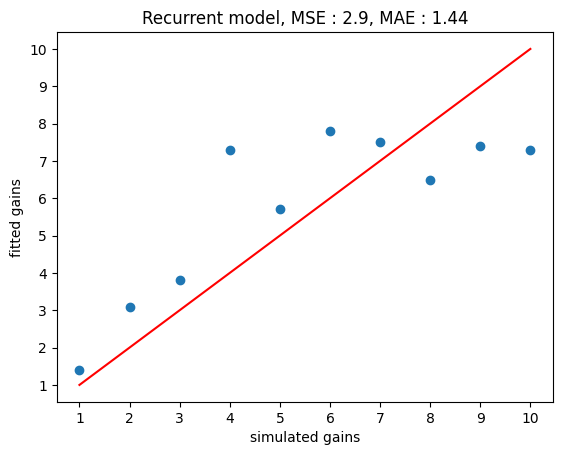

In [16]:
fig, ax = plt.subplots()

plt.xticks(all_gs)
plt.yticks(all_gs)

ax.scatter(all_gs, fitted_gs_recc)
ax.plot(all_gs, all_gs, "r")

ax.set_ylabel("fitted gains")
ax.set_xlabel("simulated gains")

ax.set_title(f"Recurrent model, MSE : {round(MSE(fitted_gs_recc, all_gs), 2)}, MAE : {round(MAE(fitted_gs_recc, all_gs), 2)}")
plt.show()

A plot depicting how good the gain parameter of our recurrent model can be recovered. The fitted gains are an average of 10 times and the red line is the "target" function so to say, which would be the best possible case, if each of our recovered parameters was on there, but as you can see, our recovered parameters are not that far off.

In [17]:
# now we do the exact same things we did before, BUT with the non recurrent model

# range of gains to try
all_gs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fitted_gs_non = []
tries = 10

# iterate over list of gains trying to find best fit
for g in all_gs:
  # inhibitory
  w_1_2=2
  w_2_1=3
  # excitory
  w_1_1=0
  w_2_2=0.0

  temp = []
  for i in range(tries):
    # simulate data based on parameters above
    created_data = model(0.6, g, 0.1, w_1_2=w_1_2, w_2_1=w_2_1, w_1_1=w_1_1, w_2_2=w_2_2, dataset=dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)
    # use recover function to determine the g, the model above used
    temp.append(recover_param_g(dataset, created_data, all_gs, w_1_2=w_1_2, w_2_1=w_2_1, w_1_1=w_1_1, w_2_2=w_2_2))
  # use average for more solid estimate of recoverbility
  fitted_gs_non.append(sum(temp) / tries)

In [18]:
print(fitted_gs_non)

[1.2, 3.1, 5.9, 6.8, 7.2, 7.0, 7.0, 5.7, 6.9, 7.7]


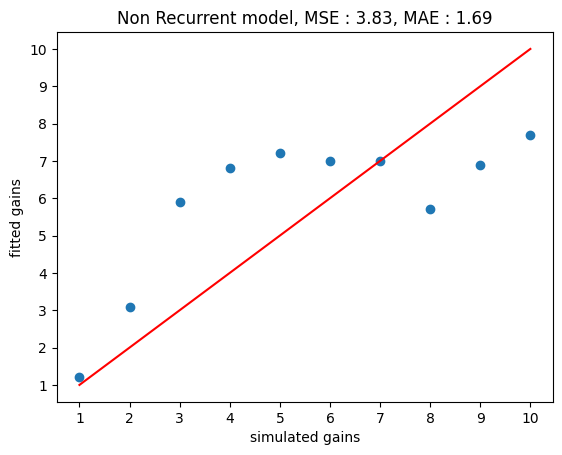

In [19]:
fig, ax = plt.subplots()

plt.xticks(all_gs)
plt.yticks(all_gs)

ax.scatter(all_gs, fitted_gs_non)
ax.plot(all_gs, all_gs, "r")

ax.set_ylabel("fitted gains")
ax.set_xlabel("simulated gains")

ax.set_title(f"Non Recurrent model, MSE : {round(MSE(fitted_gs_non, all_gs), 2)}, MAE : {round(MAE(fitted_gs_non, all_gs), 2)}")
plt.show()

A plot depicting how good the gain parameter of our non recurrent model can be recovered. The fitted gains are an average of 10 times and the red line is the "target" function so to say, which would be the best possible case, if each of our recovered parameters was on there, but as you can see, our recovered parameters are not that far off AND even better than the ones of the recurrent model.

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [20]:
def model_recover_g(rt_model_1, rt_model_2, dataset, recurrent=True, print_acc=False):
    """ recover the model that has created the provided data

    Inputs
    -------
    rt_model_1, rt_model_2: the data we try to figure out from which model the created it (usually rt_model_1 is the recurrent model and the other is non recurrent)
    dataset: the empirical dataset which the models use to do the same trials and simulate data based on
    recurrent=True: boolean, whether the model used in the recovery should be the recurrent or non recurrent one
    print_acc=False: boolean, whether to print the recovered model (mostly used for model behaviour and feedback)

    Output
    ------
    1 if the correct model was recovered else 0
    """
    best_score = 10000000
    best_model = None
    best_g = None

    # try different g for fitting
    gs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    T = 0.6        # Length of time for the control module
    sigma = 0.1   # noise

    # iterate over the range of gains
    for g in gs:
      # choose model and simulate data based on parameters above
      if recurrent:
        model_1 = model(T, g, sigma, 1, 1, 1, 0.0, dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)
      else:
        model_1 = model(T, g, sigma, 2, 3, 0, 0, dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)

      # calculate Kl divergence of simulated data and the provided data
      score_x = sum(kl_div(model_1, rt_model_1, out=None))
      score_y = sum(kl_div(model_1, rt_model_2, out=None))

      # find best fit
      if score_x < best_score:
        best_score = score_x
        best_model = "recurrent_model"
        best_g = g
      if score_y < best_score:
        best_score = score_y
        best_model = "non recurrent_model"
        best_g = g

    # useful printing for model behaviour investigation
    if print_acc:
      print("\n")
      print("best model : ", best_model)
      print("with score : ", best_score)
      print("and best g : ", best_g)

    # if recurrent model fits best and the model used for data simulation was recurrent, then success
    if recurrent and best_model == "recurrent_model":
      return 1
    # if non recurrent model fits best and the model used for data simulation was non recurrent, then success
    if not recurrent and best_model == "non recurrent_model":
      return 1
    # else we didnt recover successfully
    else:
      return 0

The function above is used by iterating (grid search) over gains and returning 1 if it successfully recovers the model that created the data, else 0.
Then we can do that process multiple times for the same g and get an average of how many times the correct model was recovered for each gain and the overall recoverbility of our models as well.

In [21]:
all_gs = [1,2,3,4,5,6,7,8,9,10]

all_fitted_rec = []
all_fitted_non = []

# this function runs like 50 minutes, just be sure you want to run this, else use our last results
sure = True
if sure:
  # iterate over all gains
  for g in all_gs:
    print('g = ',g)
    fitted_gs_recc = []
    fitted_gs_non = []

    # use multiple runs to calculate average to get more solid results
    for i in range(10):
      print(i)
      true_g = g

      # simulate data
      fit_g_recurrent = model(0.6, true_g, 0.1, w_1_2=1, w_2_1=1, w_1_1=1, w_2_2=0, dataset=dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)
      fit_g_not_recurrent = model(0.6, true_g, 0.1, w_1_2=2, w_2_1=3, w_1_1=0, w_2_2=0, dataset=dataset, I1=1, I2=1, verbose=False, print_hist=False, print_acc_and_score=False, single=True)

      # fit rec model
      score_recc = model_recover_g(fit_g_recurrent, fit_g_not_recurrent, dataset, recurrent=True, print_acc=False)
      fitted_gs_recc.append(score_recc)

      # fit non rec model
      score_non = model_recover_g(fit_g_recurrent, fit_g_not_recurrent, dataset, recurrent=False, print_acc=False)
      fitted_gs_non.append(score_non)

    # calculate average
    all_fitted_rec.append(sum(fitted_gs_recc)/len(fitted_gs_recc))
    all_fitted_non.append(sum(fitted_gs_non)/len(fitted_gs_non))

else:
  all_fitted_rec = [0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9]
  all_fitted_non = [0.6, 0.5, 0.9, 1.0, 0.9, 1.0, 0.9, 0.9, 0.8, 0.9]


g =  1
0
1
2
3
4
5
6
7
8
9
g =  2
0
1
2
3
4
5
6
7
8
9
g =  3
0
1
2
3
4
5
6
7
8
9
g =  4
0
1
2
3
4
5
6
7
8
9
g =  5
0
1
2
3
4
5
6
7
8
9
g =  6
0
1
2
3
4
5
6
7
8
9
g =  7
0
1
2
3
4
5
6
7
8
9
g =  8
0
1
2
3
4
5
6
7
8
9
g =  9
0
1
2
3
4
5
6
7
8
9
g =  10
0
1
2
3
4
5
6
7
8
9


In [22]:
# some more previous results (every run counts if you have to wait an hour for it)
#all_fitted_rec = [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
#all_fitted_non = [0.6, 0.8, 0.8, 0.9, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9]

print(all_fitted_rec)
print(all_fitted_non)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.4, 0.7, 0.8, 0.9, 0.9, 0.8, 1.0, 0.9, 1.0, 1.0]


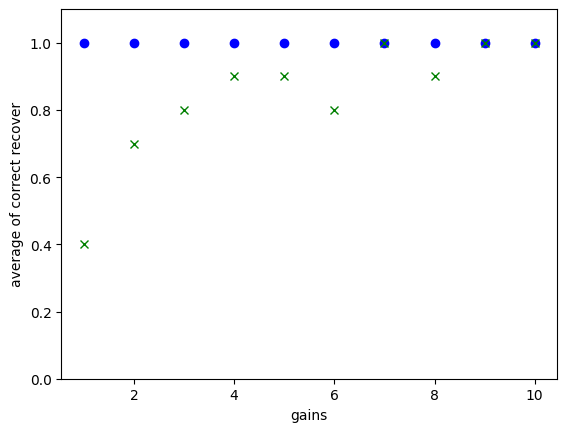

In [23]:
fig, ax = plt.subplots()

ax.plot(all_gs, all_fitted_rec, 'bo')
ax.plot(all_gs, all_fitted_non, 'gx')

ax.set_ylim(0,1.1)

ax.set_ylabel("average of correct recover")
ax.set_xlabel("gains")

plt.show()

The plot above depicts how good each model was recovered given each gain.
The blue dots are the recurrent model recovers and the green x's are for the non recurrent network.
As we can see, the recurrent model can be recoverer almost without errors, regardless of the underlying gain, while the non recurrent model struggled a bit, but overall is still pretty good recoverable.
Next we will create the confusion matrix by summing up all these recovers to get an average of how good each model was recovered.

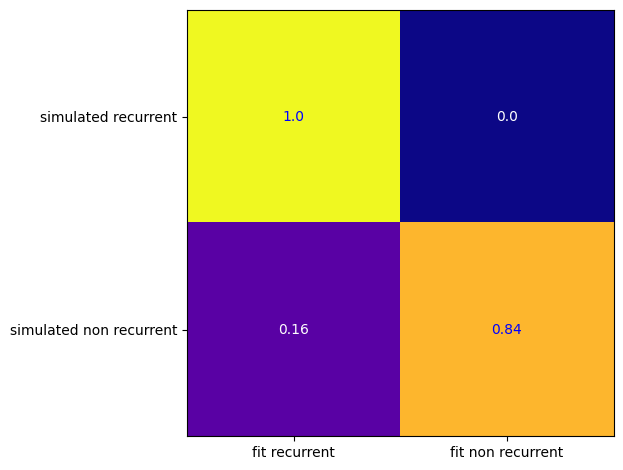

In [24]:
# calculate average
rec_avrg = sum(all_fitted_rec)/len(all_fitted_rec)
non_avrg = sum(all_fitted_non)/len(all_fitted_non)

# create confusion matrix
conf_matr = [ [rec_avrg, 1 - rec_avrg],
              [1 - non_avrg, non_avrg]
            ]

fig, ax = plt.subplots()
im = ax.imshow(conf_matr, cmap="plasma")

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
      if i==j:
        clr = "b"
      else:
        clr = "w"

      text = ax.text(j,i,round(conf_matr[i][j],3),
                      ha="center", va="center", color=clr)


# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(2), labels=["fit recurrent", "fit non recurrent"])
ax.set_yticks(np.arange(2), labels=["simulated recurrent", "simulated non recurrent"])

#ax.set_title("model fitting)")
fig.tight_layout()
plt.show()

As we saw before, the recurrent model can pretty much be recovered without errors (we used rounding here for a cleaner plot) and the non recurrent model had some trouble, but nothing too bad.

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [25]:
# params
gs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

T = 0.6        # Length of time for the control module
sigma = 0.1   # noise

best_model = None
best_g = None
best_fit = 100000

# if uncertain increase tries (use odd number for median)
tries = 5
all_fits = []
all_gs = []

for i in range(tries):
  # loop over different gains and determine best fit
  np.random.seed()
  for g in gs:
    g_recc, score_recc = model(T, g, sigma, 1, 1, 1, 0, dataset, verbose=False, print_hist=False, print_acc_and_score=False, single=False)
    g_non, score_non = model(T, g, sigma, 2, 3, 0, 0, dataset, verbose=False, print_hist=False, print_acc_and_score=False, single=False)

    if score_recc < best_fit:
      best_model = "recurrent"
      best_g = g
      best_fit = score_recc
    if score_non < best_fit:
      best_model = "non recurrent"
      best_g = g
      best_fit = score_non

  print("best fitting model : ", best_model)
  print("best fitting gain : ", best_g)
  all_fits.append(best_model)
  all_gs.append(best_g)

if tries > 1:
  choice = int((tries-1)/2)
  srt = np.argsort(all_gs)
  np.array(all_fits)[srt]
  best_model = all_fits[choice]
  best_g = all_gs[choice]

best fitting model :  non recurrent
best fitting gain :  6
best fitting model :  non recurrent
best fitting gain :  6
best fitting model :  non recurrent
best fitting gain :  6
best fitting model :  non recurrent
best fitting gain :  6
best fitting model :  non recurrent
best fitting gain :  6


Here we used the same approaches as before, since we determined a range of gains, loop over it, used KL divergence to find best fit and returned best fit after all gains have been tried out. The major difference is, that we now didnt use simulated data from our models, but the empirical data.
As we can see, the non recurrent model with a gain of 10 seems to be the best fit. This is somewhat unfortunate, as 10 is the highest gain we have tried, which begs the question, whether a greater g might fit even better. The answer should be no, since the experiment itself didnt allow for any deep concetration on any task, as each trail was random, thus an overall small g should have been most likely the best fit, but this is probably due to the nature of our very simple model we created, but nontheless, greate recoverability of paramter and model should give us some hint to the true nature of our experimental data.

model :  non recurrent
g :  6


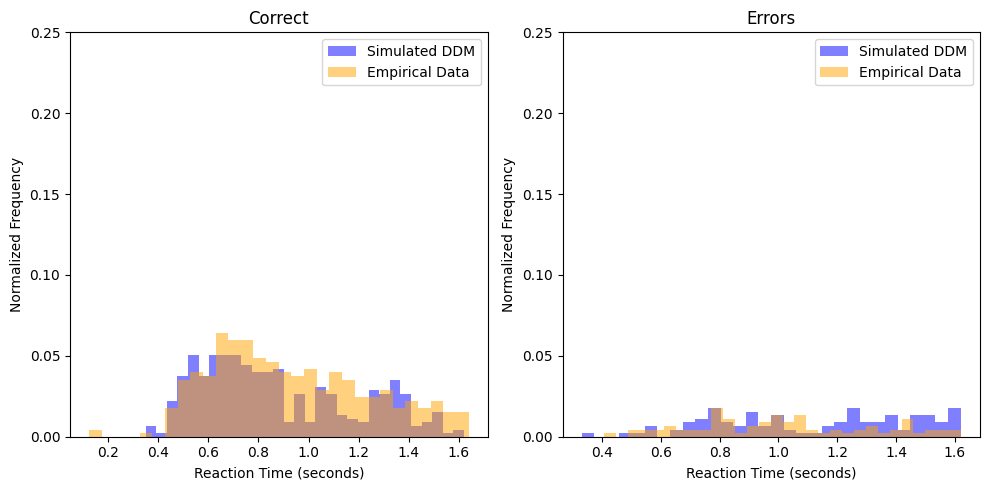

model accuracy :  0.7637969094922737
model divergence to empirical data (low == good) : 50.58460696293559


In [26]:
print("model : ", best_model)
print("g : ", best_g)
# use best fit g and model
g = best_g
T = 0.6        # Length of time for the control module
sigma = 0.1   # noise

# recurrent model
if best_model == "recurrent":
  g_recc, score_recc = model(T, g, sigma, 1, 1, 1, 0, dataset, verbose=False, print_hist=True, print_acc_and_score=True, single=False)

# non recurrent
if best_model == "non recurrent":
  g_non, score_non = model(T, g, sigma, 2, 3, 0, 0, dataset, verbose=False, print_hist=True, print_acc_and_score=True, single=False)

Now we simply plot the best fit, but most has been said above about these results.
We hope you enjoyed our notebook & model and that the comments, docstrings and text cells were enough of help to figure out our model and project design. <br>
Thanks for a great course, <br>
Cheers,<br>
Group 7